# Index and test of searches using BM25 & BM25F

## Install packages

In [1]:
!pip install git+https://github.com/terrier-org/pyterrier.git

  Cloning https://github.com/terrier-org/pyterrier.git to /tmp/pip-req-build-vs1gs2nn
  Running command git clone --filter=blob:none --quiet https://github.com/terrier-org/pyterrier.git /tmp/pip-req-build-vs1gs2nn
  Resolved https://github.com/terrier-org/pyterrier.git to commit 9fc685250800ab0910baed6699b6429202e181d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:

# !pip install python-terrier
import pyterrier as pt
# pt.init()
import pandas as pd

# Show full content of each cell
pd.set_option('display.max_colwidth', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Index news articles in dataset

In [4]:
!rm -rf ./index



In [5]:
# Load the CSV file again
df = pd.read_csv("cleaned_dataset.csv")

# Make sure the dataset contains columns of 'docno' and 'text'
if 'docno' not in df.columns or 'text' not in df.columns:
    raise ValueError("CSV file must include columns of 'docno' and 'text' ")

# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

# Clean the 'docno' field by removing quotation marks
df['docno'] = df['docno'].str.replace('"', '')

# Ensure there are no missing values in 'title' and 'text'
df = df.dropna(subset=['title', 'text'])

# Transfer dataframe to dictionary form
required_columns = ['docno', 'title', 'text']
doc_iter = df[required_columns].to_dict(orient="records")

# Create Indexer
indexer = pt.IterDictIndexer("./index", meta={'docno': 20, 'title': 512, 'text': 4096}, text_attrs=['title', 'text'],fields=True)

# Genrate Index
indexref = indexer.index(doc_iter)

# load index and print it
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


Number of documents: 3009
Number of terms: 12984
Number of postings: 173368
Number of fields: 2
Number of tokens: 273340
Field names: [title, text]
Positions:   false



# Run BM25 & BM25F on test queries

In [6]:
# A set of 15 test queries has been created to compare performance across a range of queries.



# create a mapping between different query labels in datasets
query_id_map = {
    "Q1": "Impact of interest rate hikes on stock market",
    "Q2": "Government policies affecting technology investments",
    "Q3": "Gold rush of the digital age",
    "Q4": "International geopolitical tensions",
    "Q5": "The rise of computer power",
    "Q6": "War",
    "Q7": "Japan",
    "Q8": "Merrill Lynch",
    "Q9": "Tariffs",
    "Q10": "Morgan Stanley",

}

In [7]:
for i, doc in enumerate(doc_iter[:10]):  # 看前10条
    if 'title' not in doc:
        print(f'Missing title in doc {i}:', doc)

In [8]:
# Initialize BM25 retriever
bm25 = pt.BatchRetrieve(indexref, wmodel="BM25")


# Initialise dictionary to store BM25 scores (keys correspond to queries)
results_dict = {}


# Loop through each key/query, and assign df with BM25 scores to each query key
for qid, query_text in query_id_map.items():
    single_query_df = pd.DataFrame([{"qid": qid, "query": query_text}])
    result = bm25.transform(single_query_df)
    results_dict[qid] = result

<ipython-input-8-1e0803144c64>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(indexref, wmodel="BM25")


In [9]:

def BM25F_scores(w0, w1):
    # Initialize BM25F retriever with weights
    bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})

    # Initialise dictionary to store BM25F scores (keys correspond to queries)
    results_dict_bm25f = {}

    # Loop through each key/query, and assign df with BM25F scores to each query key
    for qid, query_text in query_id_map.items():
        single_query_df = pd.DataFrame([{"qid": qid, "query": query_text}])
        result = bm25F.transform(single_query_df)
        results_dict_bm25f[qid] = result

    return results_dict_bm25f


results_dict_bm25f = BM25F_scores(1, 1)

<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})


# Import gold standard datasets

In [10]:
import pandas as pd
import os

gold_standard_df = pd.read_csv("gold_standard_combined.csv")

# Preview the result
gold_standard_df.head()


,id,title,relevance_score,query
0,4737,FIRST EASTERN CORP <FEBC> 1ST QTR NET,5.0,Bank profit report for Q4
1,5241,FIRST UNION CORP &lt;FUNC> 1ST QTR NET,5.0,Bank profit report for Q4
2,5244,FIRST COLONIAL BANKSHARES CORP &lt;FCOLA> 1ST QTR,5.0,Bank profit report for Q4
3,847,IRVING BANK &lt;V> CITES LOANS IN EARNING DECLINE,5.0,Bank profit report for Q4
4,1428,FHLBB REPORTS THRIFT RESULTS IN FOURTH QUARTER,5.0,Bank profit report for Q4


## Clean up gold standard dataset before merging

In [11]:
# Step 1: Clean ID fields of leading/trailing characters
gold_standard_df['id'] = gold_standard_df['id'].astype(str).str.strip().str.strip('"').str.strip("'")


# Standardize column names to match evaluation code
gold_standard_df.rename(columns={
    'relevance_score': 'label',
    'query': 'qid'
}, inplace=True)

# Ensure 'id' is string
gold_standard_df['id'] = gold_standard_df['id'].astype(str).str.strip().str.strip('"').str.strip("'")


# Reverse the mapping: from query string to QID
qid_map = {v: k for k, v in query_id_map.items()}

# Apply it to gold_standard_df to ensure matching keys
gold_standard_df['qid'] = gold_standard_df['qid'].map(qid_map)


# Merge golden standard dataframe with BM25/25F results

In [12]:
def merged_results_dict_func(results_dict_bm25f):
    merged_results_dict = {}

    for qid in results_dict.keys():
        result_df = results_dict[qid]
        result_bm25f_df = results_dict_bm25f[qid]

        result_df['docno'] = result_df['docno'].astype(str).str.strip().str.strip('"').str.strip("'")
        result_bm25f_df['docno'] = result_bm25f_df['docno'].astype(str).str.strip().str.strip('"').str.strip("'")

        gold_for_query = gold_standard_df[gold_standard_df['qid'] == qid].copy()

        merged_df = pd.merge(gold_for_query, result_df[['docno', 'score']], left_on='id', right_on='docno', how='left')
        merged_df.rename(columns={'score': 'BM25_score'}, inplace=True)

        merged_df = pd.merge(merged_df, result_bm25f_df[['docno', 'score']], left_on='id', right_on='docno', how='left')
        merged_df.rename(columns={'score': 'BM25F_score'}, inplace=True)

        merged_df['BM25_score'] = merged_df['BM25_score'].fillna(0)
        merged_df['BM25F_score'] = merged_df['BM25F_score'].fillna(0)

        merged_results_dict[qid] = merged_df

    return merged_results_dict

merged_results_dict = merged_results_dict_func(results_dict_bm25f)

# nDCG analysis

Interpretation of nDCG scores

| **NDCG Score Range** | **Interpretation**                               |
|----------------------|--------------------------------------------------|
| **0.9 – 1.0**         | Excellent: almost perfect ranking                |
| **0.7 – 0.9**         | Very good: highly useful search results          |
| **0.5 – 0.7**         | Moderate: useful but can be improved             |
| **0.3 – 0.5**         | Weak: many relevant items are ranked too low     |
| **< 0.3**             | Poor: ranking does not reflect relevance         |


In [13]:

import math

k_max = 50
k_values = list(range(10, 51, 10))

def dcg(relevances):
    return sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(relevances)])

def ndcg(sorted_relevances, ideal_relevances):
    return dcg(sorted_relevances) / dcg(ideal_relevances) if dcg(ideal_relevances) > 0 else 0


def ndcg_results_func():

    ndcg_results = {'BM25': {}, 'BM25F': {}}

    for k in k_values:
        ndcg_bm25 = []
        ndcg_bm25f = []

        for qid, df in merged_results_dict.items():
            # BM25
            bm25_sorted = df.sort_values('BM25_score', ascending=False)['label'].tolist()[:k]
            ideal_sorted = sorted(df['label'], reverse=True)[:k]
            ndcg_bm25.append(ndcg(bm25_sorted, ideal_sorted))

            # BM25F
            bm25f_sorted = df.sort_values('BM25F_score', ascending=False)['label'].tolist()[:k]
            ndcg_bm25f.append(ndcg(bm25f_sorted, ideal_sorted))

        ndcg_results['BM25'][k] = sum(ndcg_bm25) / len(ndcg_bm25)
        ndcg_results['BM25F'][k] = sum(ndcg_bm25f) / len(ndcg_bm25f)

    return ndcg_results

ndcg_results = ndcg_results_func()


# Visualisation of results

In [14]:
def visualisation_per_query(w0, w1):
    # Compute per-query nDCG@k for BM25 and BM25F
    per_query_ndcg = {qid: {"BM25": [], "BM25F": []} for qid in merged_results_dict.keys()}

    for k in k_values:
        for qid, df in merged_results_dict.items():
            ideal_sorted = sorted(df["label"], reverse=True)[:k]

            # BM25
            bm25_sorted = df.sort_values("BM25_score", ascending=False)["label"].tolist()[:k]
            per_query_ndcg[qid]["BM25"].append(ndcg(bm25_sorted, ideal_sorted))

            # BM25F
            bm25f_sorted = df.sort_values("BM25F_score", ascending=False)["label"].tolist()[:k]
            per_query_ndcg[qid]["BM25F"].append(ndcg(bm25f_sorted, ideal_sorted))

    # Limit number of queries to plot
    selected_qids = list(per_query_ndcg.keys())

    # Determine grid layout
    n_queries = len(selected_qids)
    cols = 2
    rows = math.ceil(n_queries / cols)

    # Create grid plot
    fig, axs = plt.subplots(rows, cols, figsize=(14, rows * 4))
    axs = axs.flatten()

    for idx, qid in enumerate(selected_qids):
        ax = axs[idx]
        ax.plot(k_values, per_query_ndcg[qid]["BM25"], marker='o', label="BM25")
        ax.plot(k_values, per_query_ndcg[qid]["BM25F"], marker='x', label="BM25F")
        query_text = query_id_map[qid]
        ax.set_title(f"Query: {query_text}", fontsize=10)
        ax.set_xlabel("k")
        ax.set_ylabel("nDCG@k")
        ax.set_ylim(0, 1)
        ax.grid(True)
        ax.legend()

    # Hide any unused subplots
    for idx in range(n_queries, len(axs)):
        axs[idx].axis("off")

    # Add a single super-title with weight info
    fig.suptitle(f"BM25F Weights: w0 = {w0}, w1 = {w1}", fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

In [15]:
import matplotlib.pyplot as plt

def ndcg_visualise():


    # Extract values for plotting
    k_vals = list(ndcg_results['BM25'].keys())
    bm25_scores = [ndcg_results['BM25'][k] for k in k_vals]
    bm25f_scores = [ndcg_results['BM25F'][k] for k in k_vals]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(k_vals, bm25_scores, marker='o', label='BM25')
    plt.plot(k_vals, bm25f_scores, marker='o', label='BM25F')
    plt.title('nDCG@k Comparison: BM25 vs BM25F')
    plt.xlabel('k')
    plt.ylabel('Average nDCG@k')
    plt.xticks(k_vals)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




# Query per row comparison

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

def visualise_all_query_lines_across_weights(weight_combos=[(1, 1), (5, 0.5), (0.5, 5)]):
    selected_qids = list(query_id_map.keys())
    n_combos = len(weight_combos)

    # Step 1: Build a dict of { (w0, w1): merged_results_dict }
    combo_results = {}
    for w0, w1 in weight_combos:
        results_dict_bm25f = BM25F_scores(w0=w0, w1=w1)
        merged_results_dict_local = merged_results_dict_func(results_dict_bm25f)
        combo_results[(w0, w1)] = merged_results_dict_local

    # Step 2: Rank queries by best BM25F score at highest k
    performance_summary = []
    for (w0, w1), merged in combo_results.items():
        for qid in selected_qids:
            df = merged[qid]
            ideal_sorted = sorted(df["label"], reverse=True)[:k_values[-1]]
            bm25f_sorted = df.sort_values("BM25F_score", ascending=False)["label"].tolist()[:k_values[-1]]
            score = ndcg(bm25f_sorted, ideal_sorted)
            performance_summary.append((qid, w0, w1, score))

    best_combo_by_query = defaultdict(lambda: (None, -1))
    for qid, w0, w1, score in performance_summary:
        if score > best_combo_by_query[qid][1]:
            best_combo_by_query[qid] = ((w0, w1), score)

    sorted_qids = sorted(selected_qids, key=lambda qid: best_combo_by_query[qid][1], reverse=True)

    # Step 3: Plot setup
    fig, axs = plt.subplots(len(sorted_qids), n_combos, figsize=(5 * n_combos, 4 * len(sorted_qids)), squeeze=False)

    for col, (w0, w1) in enumerate(weight_combos):
        merged_results_dict_this_combo = combo_results[(w0, w1)]

        per_query_ndcg = {qid: {"BM25": [], "BM25F": []} for qid in sorted_qids}
        for k in k_values:
            for qid in sorted_qids:
                df = merged_results_dict_this_combo[qid]
                ideal_sorted = sorted(df["label"], reverse=True)[:k]

                bm25_sorted = df.sort_values("BM25_score", ascending=False)["label"].tolist()[:k]
                bm25f_sorted = df.sort_values("BM25F_score", ascending=False)["label"].tolist()[:k]

                per_query_ndcg[qid]["BM25"].append(ndcg(bm25_sorted, ideal_sorted))
                per_query_ndcg[qid]["BM25F"].append(ndcg(bm25f_sorted, ideal_sorted))

        for row, qid in enumerate(sorted_qids):
            ax = axs[row][col]
            ax.plot(k_values, per_query_ndcg[qid]["BM25"], marker='o', label="BM25")
            ax.plot(k_values, per_query_ndcg[qid]["BM25F"], marker='x', label="BM25F")
            ax.set_ylim(0, 1)
            ax.set_title(f"w0={w0}, w1={w1}", fontsize=10)

            if col == 0:
                ax.set_ylabel(query_id_map[qid], fontsize=9)
            if row == 0 and col == 0:
                ax.legend()
            if row == len(sorted_qids) - 1:
                ax.set_xlabel("k")

    fig.suptitle("BM25 vs BM25F Performance Per Query (Sorted by Best BM25F @k)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()




Average nDCG @ k across ALL queries:
-------------------------------------


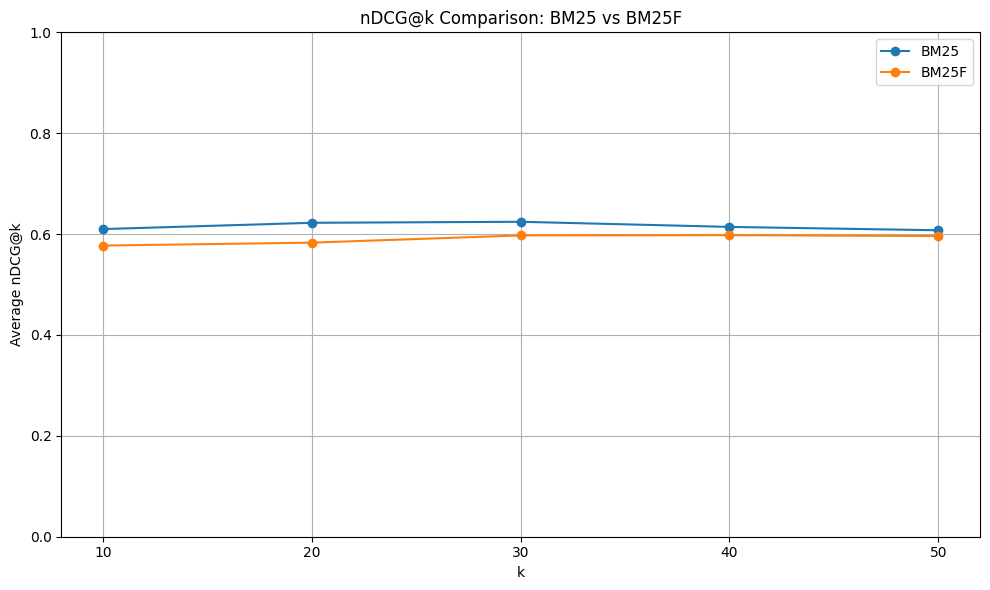

nDCG @ k PER query:
-------------------------------------


<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})
<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})
<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})


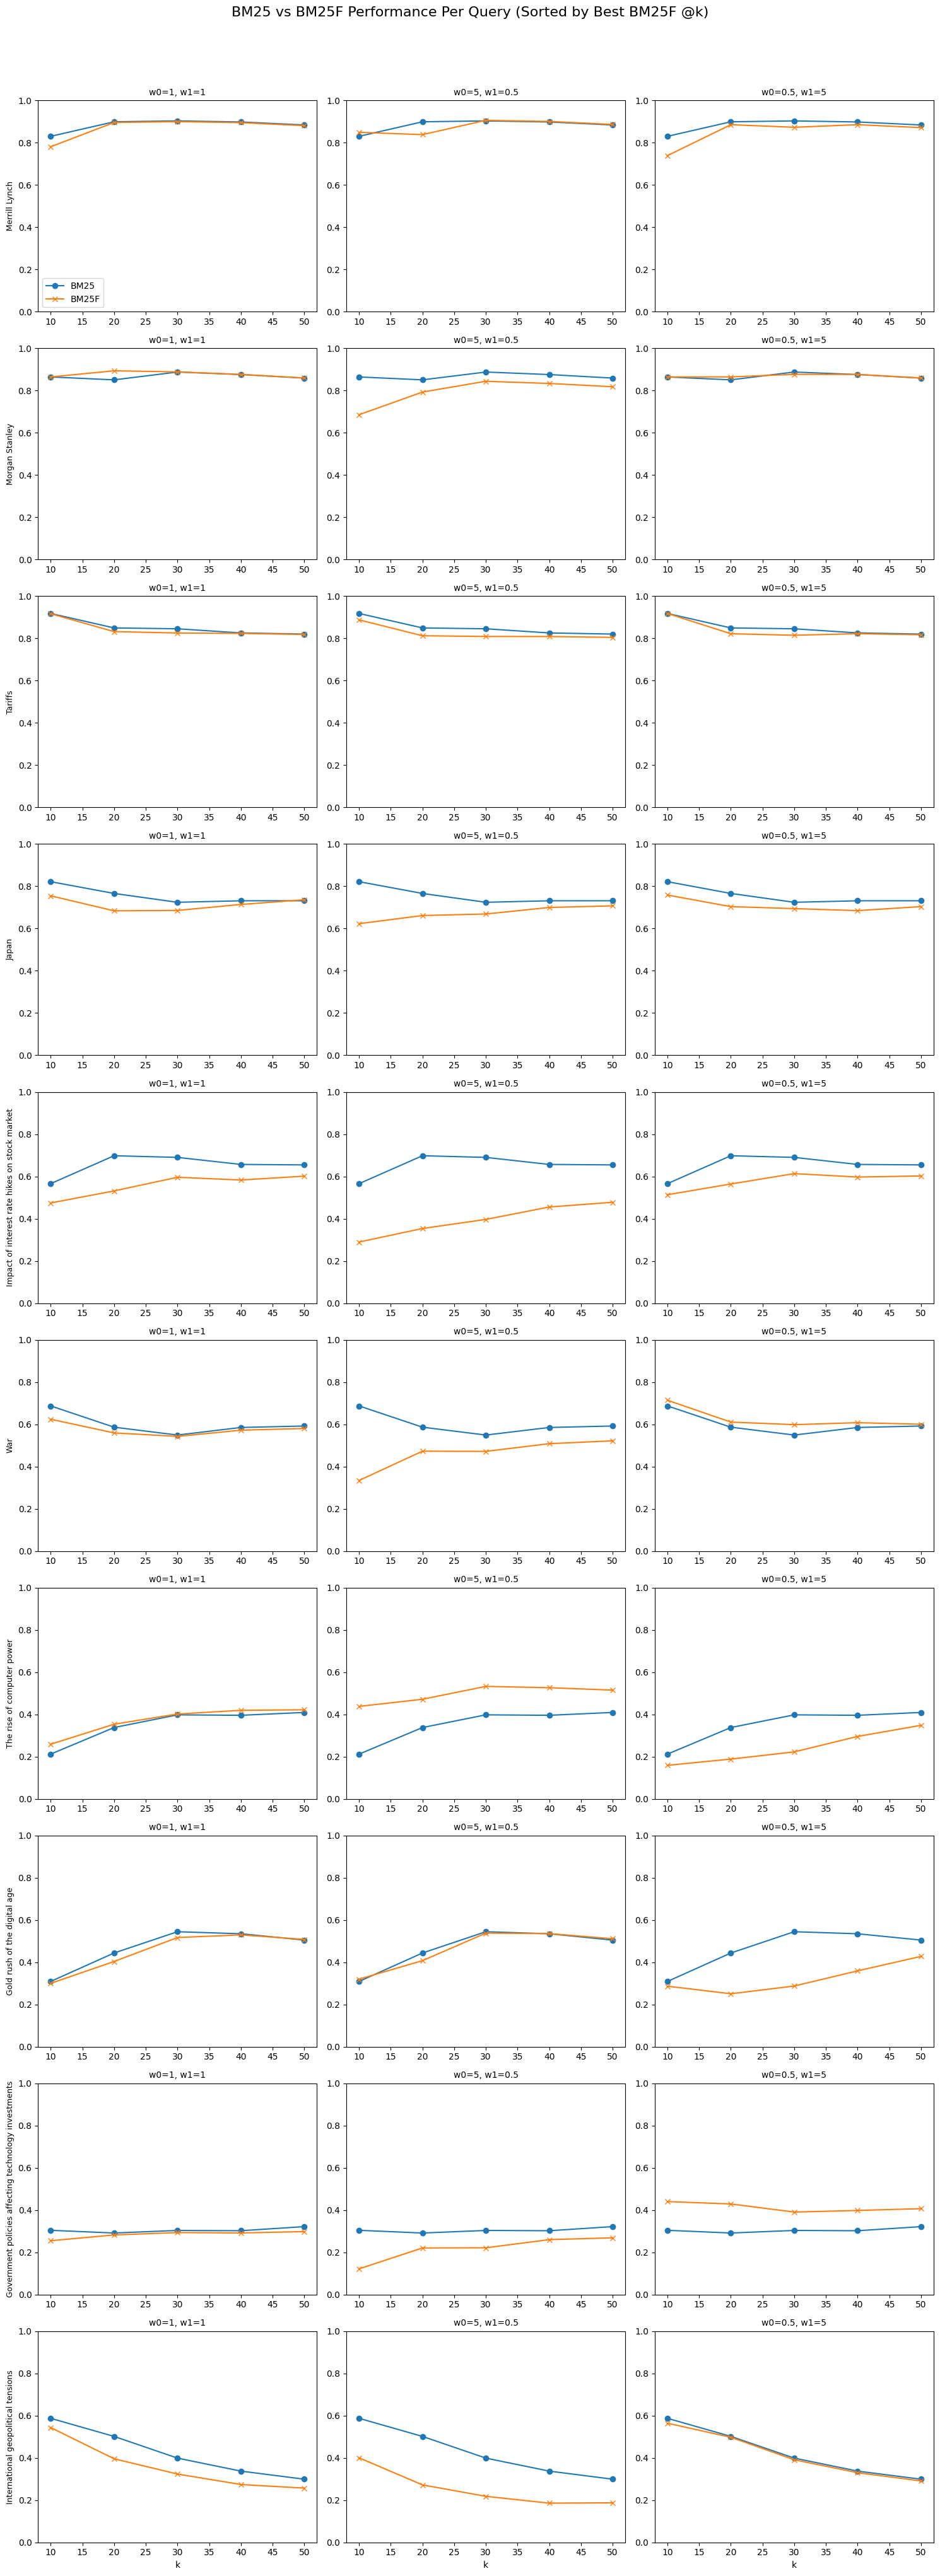

In [17]:
print("Average nDCG @ k across ALL queries:")
print("-------------------------------------")
ndcg_visualise()


print("nDCG @ k PER query:")
print("-------------------------------------")
visualise_all_query_lines_across_weights(weight_combos=[(1, 1), (5, 0.5), (0.5, 5)]);

# Per query improvements

In [18]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# Define the weight combinations you want to compare
weight_combos = [(1, 1), (5, 0.5), (0.5, 5)]

# This will hold all results
all_rows = []

# Loop through each weight combo
for w0, w1 in weight_combos:
    results_dict_bm25f = BM25F_scores(w0=w0, w1=w1)
    merged_results_dict = merged_results_dict_func(results_dict_bm25f)

    for qid, df in merged_results_dict.items():
        bm25_sorted = df.sort_values('BM25_score', ascending=False)['label'].tolist()[:k_max]
        bm25f_sorted = df.sort_values('BM25F_score', ascending=False)['label'].tolist()[:k_max]
        ideal_sorted = sorted(df['label'], reverse=True)[:k_max]

        ndcg_bm25 = ndcg(bm25_sorted, ideal_sorted)
        ndcg_bm25f = ndcg(bm25f_sorted, ideal_sorted)

        all_rows.append({
            "Query": query_id_map[qid],
            "qid": qid,
            "w0": w0,
            "w1": w1,
            "BM25": ndcg_bm25,
            "BM25F": ndcg_bm25f,
            "Improvement": ndcg_bm25f - ndcg_bm25,
            "% Gain": ((ndcg_bm25f - ndcg_bm25) / ndcg_bm25) * 100 if ndcg_bm25 > 0 else None
        })

# Convert to DataFrame
df_all = pd.DataFrame(all_rows)
df_all = df_all[['Query', 'qid', 'w0', 'w1', 'BM25', 'BM25F', 'Improvement', '% Gain']]
df_all = df_all.sort_values(by=['Query', 'Improvement'], ascending=[True, False])





<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})
<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})
<ipython-input-9-d1037e5cb999>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25F = pt.BatchRetrieve(indexref, wmodel="BM25F", properties = {'w.0': w0, 'w.1': w1})


# queries where BM25F gave the biggest relative improvement over BM25

In [19]:
df_all.sort_values(by='% Gain', ascending=False).head(5)

,Query,qid,w0,w1,BM25,BM25F,Improvement,% Gain
21,Government policies affecting technology investments,Q2,0.5,5.0,0.321578,0.406521,0.084943,26.414471
14,The rise of computer power,Q5,5.0,0.5,0.409001,0.514764,0.105762,25.858708
4,The rise of computer power,Q5,1.0,1.0,0.409001,0.421603,0.012602,3.081101
25,War,Q6,0.5,5.0,0.591572,0.600024,0.008451,1.428630
12,Gold rush of the digital age,Q3,5.0,0.5,0.504704,0.510971,0.006267,1.241727


# queries where BM25F gave the worst relative performance compared to BM25

In [20]:
df_all.sort_values(by='% Gain', ascending=True).head(5)

,Query,qid,w0,w1,BM25,BM25F,Improvement,% Gain
13,International geopolitical tensions,Q4,5.0,0.5,0.299243,0.187310,-0.111934,-37.405591
10,Impact of interest rate hikes on stock market,Q1,5.0,0.5,0.654325,0.477415,-0.176910,-27.037049
11,Government policies affecting technology investments,Q2,5.0,0.5,0.321578,0.268480,-0.053098,-16.511617
22,Gold rush of the digital age,Q3,0.5,5.0,0.504704,0.427447,-0.077258,-15.307483
24,The rise of computer power,Q5,0.5,5.0,0.409001,0.348007,-0.060994,-14.912926
